In [1]:
from scipy.integrate import solve_bvp, odeint
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import glob
from scipy import interpolate
from scipy import integrate

array([0.00000000e+00, 6.33159497e+14, 6.85833222e+14, ...,
       2.63371715e+14, 2.62705806e+14, 2.62041577e+14])

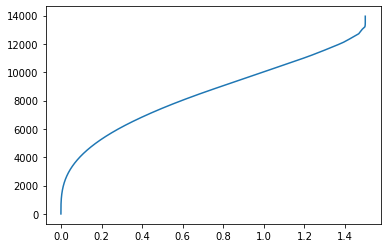

In [122]:
df = np.genfromtxt('/Users/laote/sdsu/Research/GRR/mass_energy_density_profiles.dat'\
                   ,skip_header=7,skip_footer=1,names='rd,mr,ed,nd')
bar_rho = (3*df['mr']*1.988e30/(4*np.pi*df['rd']**3))
plt.plot(df['mr'],df['rd'])

df = np.genfromtxt('/Users/laote/sdsu/Research/GRR/mass_energy_density_profiles.dat'\
               ,skip_header=7,skip_footer=1,names='rd,mr,ed,nd')
M = df['mr']*1.988e33 # to gram
R = df['rd']*100 # to cm
rho = (3*M/(4*np.pi*R**3))
rho

In [2]:
def freq_omega(Omega): # eigen frequency
    
    return 1

def alpha_m(m,M,R,period=0): # period is in unit second
    if period == 0:
        return 1
    else:
        # (piGrho) 3/4* gravitational constant in solar mass^-1*km^3*sec^-2 = 9.95e10
        unit = (9.95e10*(M/R**3))**(-0.5) # in solar mass and km
        template = np.genfromtxt("./Constant/alpha%s.txt"%m,names=('x,y'))
        f = interpolate.interp1d(template['x'], template['y'])

        freq = (2*np.pi/period)*(unit)
        if freq > 0.65:
            freq = 0.65

        am = f(freq)
        return round(np.float(am),5)
#         return 1

def gamma_m(m,M,R,period=0): # period is in unit second
    if period == 0:
        return 1
    else:
        unit = (9.95e10*(M/R**3))**(-0.5) # in solar mass and km
        template = np.genfromtxt("./Constant/gamma%s.txt"%m,names=('x,y'))
        f = interpolate.interp1d(template['x'], template['y'])

        freq = (2*np.pi/period)*(unit)
        if freq > 0.65:
            freq = 0.65

        gm = f(freq)

        return round(np.float(gm),5)
    
def epslion_m(m):
    return 1


def omega_m(m,M,R): # mass and radius (equation 16.70)
    col1 = 2*m*(m - 1)/(2*m + 1)
    col2 = 6.67e-20*M*2e30/R**3
    om = np.sqrt(col1 * col2)
    return om

In [3]:
def doublefactorial(n): 
    if (n == 0 or n == 1): 
        return 1; 
    return n * doublefactorial(n - 2);


def tau_GR_m(m,M,R): # m >= 0, mass, radius
    col1 = ( (m-1) * (doublefactorial(2*m+1))**2 ) / ( (m+1) * (m+2) )
    col2 = ( (2*m + 1) / (2*m*(m-1)) )**m
    col3 = 2/3 * (R/(M*1.48))**(m+1) * R/3e5
    tGRm = col1 * col2 * col3
    return tGRm

def tau_nu_m(m,R,nu): # radius (km), shear viscosity timescale (equaiton 16.72)
    tnum = (R*1e5)**2 / ((2*m+1)*(m-1)) / nu
    return tnum

def tau_zeta_m(m,M,R,zeta): # mass(sun mass) radius (km)
    tzetam = (0.5*(3/5)**4*(m**3/(2*m+3))*zeta/R**2)**(-1)
    return tzetam

tau_GR_m(2,1.4,12),tau_nu_m(2,12,0.01),tau_zeta_m(2,1.4,12,0.01)

(0.1517625150807423, 28800000000000.0, 194444.44444444447)

psi''(r) + 2/r*psi'(r) + [a-b/r**2]*psi(r) + c*(r**3) = 0

psi'(r) = omega(t)

omega'(t) = -2/r*omega(t) - [a-b/r**2]*psi(r) - c*(r**3)

In [4]:
def ode_RK4(f, t0, tf, y0=0, n=100):
    t = np.linspace(t0,tf,n)
    y = list([y0])
    for i in range(n-1):
        h = t[i+1]-t[i]
        k1 = h*f(t[i],y[-1])
        k2 = h*f(t[i]+h/2,y[-1]+k1/2)
        k3 = h*f(t[i]+h/2,y[-1]+k2/2)
        k4 = h*f(t[i]+h,y[-1]+k3)
        y.append(y[-1]+(k1+2*k2+2*k3+k4)/6)
    y = np.array(y)
    
    return y

def ode_shooting(F,t0,tf,y0,yf,n=100,tol=10**(-8),kmax=10):
    
    yp0 = float(yf-y0)/(tf-t0)
    Y0 = np.array((y0,yp0))
    Y = ode_RK4(F,t0,tf,Y0,n)
    err = Y[-1][0] - yf
    Y0[1] = yp0 - 0.1*np.sign(err)
    for k in range(kmax-1):
        Y = ode_RK4(F,t0,tf,Y0,n)
        err1 = Y[-1][0] - yf
        ddy = Y0[1] - yp0
        if abs(err1)<tol or abs(ddy)<tol:
            y = list()
            for x in Y:
                y.append(x[0])
            return np.array(y), Y0[1], err
        deddy = (err1-err)/ddy
        yp0 = Y0[1]
        err = err1
        Y0[1] = Y0[1] - err/deddy
    y = list()
    for x in Y:
        y.append(x[0])
    return np.array(y), Y0[1], err

In [5]:
def F(t,Y):
    const = 3.479e-12 #cm^-2
    l = 2
    R = 13*1e5 #cm
    a = const - (l+1)*(l+2)/t**2 #cm^-2
    b = 2/t #cm^-1
    c = -2*const*l/(2*l+1)*np.sqrt(l/(l+1))*(t/R)**(l+1)

    return np.array([Y[1],c-b*Y[1]-a*Y[0]])

def testfun(x):
    y = (2 *np.exp(18 - 3*x) *(-1 + np.exp(3 *x)))/(-1 + np.exp(18))
    return y

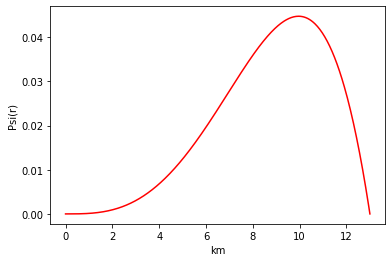

array(0.0447581)

In [6]:
y,yp,err = ode_shooting(F,1e-13,13*1e5,0,0,n=500)
t = np.linspace(1e-13,13,500)
# yy = testfun(t)
plt.plot(t,y,'r')
plt.xlabel('km')
plt.ylabel('Psi(r)')
# plt.xlim(0,13)
# plt.plot(t,yy,'c.')
plt.show()
f = interpolate.interp1d(t, y)
f(10)

In [7]:
# 4pi * gravitational constant* g^2/dyn/cm^4 = 8.387e-7 cm^-2
3.479e-12 #cm^-2
2e15*(0.27137183E+03-0.26789075E+03)*1.7827*10**12/((0.33932533E+02-0.32064907E+02)*1.6022*10**33) #g^2/dyn/cm^4

#drho_dp in sec^2/cm^2
(0.27137183E+03-0.26789075E+03)*1.7827*10**12/((0.33932533E+02-0.32064907E+02)*1.6022*10**33)

2.073889581536933e-21

In [273]:
def NS_density(r):
    df = np.genfromtxt('/Users/laote/sdsu/Research/GRR/mass_energy_density_profiles.dat'\
                   ,skip_header=7,skip_footer=1,names='rd,mr,ed,nd')
    M = df['mr']*1.988e33 # to gram
    R = df['rd']*100 # to cm
    pos = np.argmin(np.abs(R-r))
    m = M[pos]
#     func = interpolate.interp1d(R,M)
#     m = func(r)
#     m = 1.5*1.988e33
#     r = 14e5
    rho = (3*m/(4*np.pi*r**3))
    
    return rho

def int_term_2(r,M=1.4,R=12.53,l=2,period=7.465e-4,y=[0,0]): 
    # M in solar mass, r and R in unit km, period in unit sec
#     t = np.linspace(1e-13,R,100)
#     f = interpolate.interp1d(t, y)
#     d_psi = f(r)
    d_psi = 0
    if period == 0:
        Omega = np.sqrt(9.95e10*(M/R**3))
    else:   
        Omega = 2*np.pi/period
    alpha = 1
    drho_dp = 2.0739e-21 #sec^2/cm^2
    drho_rho = alpha * (R)**2 * Omega**2 * drho_dp *\
               ( (2*l/(2*l+1) ) * np.sqrt(l/(l+1)) * (r/R)**(l+1) + d_psi)
    density = NS_density(r)
    temp = 1e9 # unit K
    zeta = 6e-59 * ((l+1)/(2*Omega))**2 * density**2 * temp**6
    
    func = zeta * drho_rho**2 * r**2 * 2*np.pi
    
    return func

def int_term_2_SH(theta,l=2): #spherical, theta goes from 0 to pi/2
    if l == 2:
        y = 2*np.pi* (-1/2)*np.sqrt(15/2/np.pi) * np.sin(theta)*np.cos(theta) 
    if l == 3:
        y = 2*np.pi* (1/4)*np.sqrt(105/2/np.pi) * np.sin(theta)**2*np.cos(theta) 
    if l == 4:
        y = 2*np.pi* (-3/8)*np.sqrt(35/np.pi) * np.sin(theta)**3*np.cos(theta) 
    if l == 5:
        y = 2*np.pi* (3/16)*np.sqrt(385/2/np.pi) * np.sin(theta)**4*np.cos(theta) 
    if l == 6:
        y = 2*np.pi* (-3/32)*np.sqrt(1001/2/np.pi) * np.sin(theta)**5*np.cos(theta)   
    else:
        y = 1
    return y**2
    

def int_shear_term_2(r,M=1.4,R=12.53,l=2):
    density = NS_density(r)
    temp = 1e9 # unit K
    shear = 347 * density**(9/4) * temp**(-2)
    func = density * r**(2*l)
    return func

def int_term_3(r,M=1.4,R=12.53,l=2):
    density = NS_density(r)
    func = density * r**(2*l+2)
    return func


def shear_timescale(l,M,R): # mass(sun mass) radius (km)
    R=R*1e5 #unit to cm
    
    int_lim = np.linspace(60,R,500)
    term2,term3 = 0,0
    for il in int_lim:
        term2 += int_shear_term_2(il,M,R,l)*(R-60)/100
        term3 += int_term_3(il,M,R,l)*(R-60)/100
#     term2 = integrate.quad(int_shear_term_2, 60, R, args=(M,R,l))[0]
#     term3 = integrate.quad(int_term_3, 60, R, args=(M,R,l))[0]
    tzetam = (l-1)*(2*l+1) * term2 * (term3)**(-1)
    return 1/tzetam
    
    
def bulk_timescale(l,M,R,period): # mass(sun mass) radius (km)
    R=R*1e5 #unit to cm
    
#     y,yp,err = ode_shooting(F,1e-13,R,0,0,n=100)
    y=[0,0]
    
    int_lim = np.linspace(60,R,100)
    term2,term2_SH,term3 = 0,0,0
    for il in int_lim:
        term2 += int_term_2(il,M,R,l,period,y)*(R-60)/100
        term3 += int_term_3(il,M,R,l)*(R-60)/100
    
#     term2 = integrate.quad(int_term_2, 0.001, R, args=(M,R,l,period,y))[0]
    term2_SH = integrate.quad(int_term_2_SH, 0, np.pi, args=(l))[0]
#     term3 = integrate.quad(int_term_3, 0.001, R, args=(M,R,l))[0]
    tzetam = 4*(R)**(2*l-2)/(l+1)**2 * term2 * np.abs(term2_SH) * (term3)**(-1)
    return 1/tzetam

In [274]:
def Omega_GRR(m,M,R,nu,period=0): # mass, radius, shear viscosity, period
    col1 = omega_m(m,M,R)/m
    col2 = alpha_m(m,M,R,period) 
    col_25 = tau_GR_m(m,M,R)/shear_timescale(m,R,nu) + tau_GR_m(m,M,R)/bulk_timescale(m,M,R,period)*epslion_m(m)
    col3 = gamma_m(m,M,R,period) * (col_25)**(1/(2*m+1))
    GRR = col1 * (col2 + col3)
    return GRR

def self_con_Omega_GRR(m,M,R,nu,period=0):
    p = []
    for i in range(30):
        O = 2*np.pi/Omega_GRR(m,M,R,nu,period)
        p.append(O)
#     plt.figure(figsize=(10,5))
#     plt.plot(p)
#     plt.show()
    final_p = 0.5*(p[-1]+p[-2])
    return np.round(final_p,7) # in unit second

[2.13527747e+11 8.45273703e+10 4.65598070e+10 2.97254614e+10
 2.06913051e+10]
[1.94e+11 8.60e+10 4.90e+10 2.99e+10 1.78e+10]


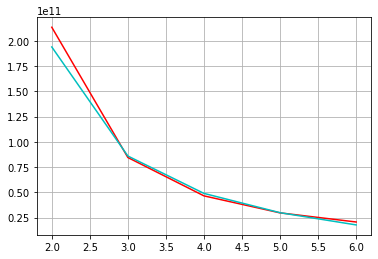

In [275]:
shearx = []
for l in range(2,7):
    shearx.append(shear_timescale(l,1.4,12.53))
shearx = np.array(shearx)
print(shearx)


testy = np.array([2.52e8,1.44e8,1.07e8,8.79e7,7.58e7])*1e3-5.8e10
print(testy)
plt.plot([2,3,4,5,6],shearx,'r')
plt.plot([2,3,4,5,6],testy,'c')
plt.grid()
# plt.xlim(3,6)

array([5.78220771e+08, 4.33097031e+08, 3.70290894e+08, 3.35698686e+08,
       2.76934621e+08])

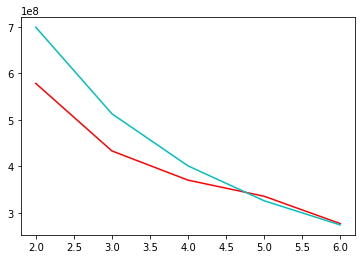

In [276]:
testx = []
for l in range(2,7):
    testx.append(bulk_timescale(l,1.4,12.53,7.465e-4))
testx = np.array(testx)/100*4.4

testy = np.array([6.99e8,5.13e8,4.01e8,3.26e8,2.74e8])
testx,testy


plt.plot([2,3,4,5,6],testx,'r')
plt.plot([2,3,4,5,6],testy,'c')

testx

In [278]:
# x = np.logspace(-7,1,30)
# y = []

# for xx in x:
#     y.append(self_con_Omega_GRR(2,1.4,13,2,xx)*1000)
    
# plt.plot(x,y)
# plt.ylabel('period(ms)')
# plt.xscale('log')
# plt.grid()
# plt.show()


# testx = []
# for l in range(2,7):
#     testx.append(bulk_timescale(l,1.4,12.53,7.465e-4))
# testx = np.array(testx)

# testy = np.array([6.99e8,5.13e8,4.01e8,3.26e8,2.74e8])
# testx,testy

In [ ]:
sv = np.array([200,1,0.1,0.01,0.001])
# y = self_con_Omega_GRR(3,1.3,11,0.01,0)*1000
# print(y)

mass = 1.5
radius = 13.8
plt.figure(figsize=(10,5))
for m in range(2,6):
    y = []
    for x in sv:
        y.append(self_con_Omega_GRR(m,mass,radius,x,1)*1000)
        plt.annotate(x,(y[-1],m))
    plt.plot(y,[m,m,m,m,m],'o-')
plt.xlabel('Period (ms)')
plt.ylabel('m')
# plt.xlim(1,1.5)
plt.show()

# plt.figure(figsize=(10,5))
# for m in range(2,6):
#     y = []
#     for x in sv:
#         y.append(2*np.pi/Omega_GRR(m,mass,radius,x,1)*1000)
#         plt.annotate(x,(y[-1],m))
#     plt.plot(y,[m,m,m,m,m],'o-')
# plt.xlabel('Period (ms)')
# plt.ylabel('m')
# plt.xlim(1,1.5)
# plt.show()

In [280]:
basedir = "/Users/laote/sdsu/Research/rotation"
twindir = basedir + "/EOS_twin"

In [ ]:
i = 3
datadir = twindir + "/%s.dat" %(i)
dataHT2 = np.genfromtxt(datadir,skip_header=649, skip_footer=1028-710,\
                        names='number,e_c,e_c_e_0,M_gr,M_by,M_pr,R_km,lg_A_rot,lg_I_g_cm2')
NSdir = twindir + "/outputHT.dat__HVfull"
NSHT2 = np.genfromtxt(NSdir,skip_header=753, skip_footer=1196-822,\
                         names='number,e_c,e_c_e_0,M_gr,M_by,M_pr,R_km,lg_A_rot,lg_I_g_cm2')
# NSdir = twindir + "/brockB+HFV.dat"
# NSHT2 = np.genfromtxt(NSdir,skip_header=649, skip_footer=1028-710,\
#                         names='number,e_c,e_c_e_0,M_gr,M_by,M_pr,R_km,lg_A_rot,lg_I_g_cm2')


M_gr = dataHT2['M_gr']
R = dataHT2['R_km']

NSM_gr = NSHT2['M_gr']
NSR = NSHT2['R_km']


plt.figure(figsize=(15,5))
plt.suptitle('m = 3, EoS = Multipoly_ACB4_GrigorConstr_k1_DeltaP=3')
plt.subplot(131)
for bb in sv:
    period = []
    for i in range(len(M_gr)):
        period.append(self_con_Omega_GRR(3,M_gr[i],R[i],bb,1)*1000)
    plt.plot(M_gr,period,'o-',label = 'v = %s' %bb)
plt.ylabel('Period (ms)')
plt.xlabel('mass')
plt.grid()
plt.legend()

plt.subplot(132)
for bb in sv:
    period = []
    for i in range(len(M_gr)):
        period.append(self_con_Omega_GRR(3,M_gr[i],R[i],bb,1)*1000)
    plt.plot(R,period,'o-',label = 'v = %s' %bb)
plt.ylabel('Period (ms)')
plt.xlabel('radius')
plt.grid()
plt.legend()

plt.subplot(133)
for bb in sv:
    plt.plot(R,M_gr,'o-',label = 'v = %s' %bb)
plt.ylabel('mass')
plt.xlabel('radius')
plt.grid()
plt.legend()

plt.show()

plt.figure(figsize=(15,5))
plt.suptitle('m = 3, EoS = brockB+HFV')
plt.subplot(131)
for bb in sv:
    period = []
    for i in range(len(NSM_gr)):
        period.append(self_con_Omega_GRR(3,NSM_gr[i],NSR[i],bb,1)*1000)
    plt.plot(NSM_gr,period,'o-',label = 'v = %s' %bb)
plt.ylabel('Period (ms)')
plt.xlabel('mass')
plt.grid()
plt.legend()

plt.subplot(132)
for bb in sv:
    period = []
    for i in range(len(NSM_gr)):
        period.append(self_con_Omega_GRR(3,NSM_gr[i],NSR[i],bb,1)*1000)
    plt.plot(NSR,period,'o-',label = 'v = %s' %bb)
plt.ylabel('Period (ms)')
plt.xlabel('radius')
plt.grid()
plt.legend()

plt.subplot(133)
for bb in sv:
    plt.plot(NSR,NSM_gr,'o-',label = 'v = %s' %bb)
plt.ylabel('mass')
plt.xlabel('radius')
plt.grid()
plt.legend()

plt.show()